## 1. Setup & Install Dependencies

In [8]:
# Install Evidently jika belum ada
!pip install evidently -q



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
from datetime import datetime

# Evidently (versi 0.7.x)
from evidently import Report
from evidently.presets import DataDriftPreset, RegressionPreset, DataSummaryPreset
from evidently.metrics import DriftedColumnsCount, ValueDrift

# Scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Paths
PROCESSED_DATA_DIR = Path('../data/processed')
MODELS_DIR = Path('../models')
REPORTS_DIR = Path('../reports')
MONITORING_DIR = Path('../monitoring')
MONITORING_DIR.mkdir(exist_ok=True)

print("✅ Setup complete!")


✅ Setup complete!


## 2. Load Data & Model

In [10]:
# Load processed data
train_df = pd.read_parquet(PROCESSED_DATA_DIR / 'train.parquet')
val_df = pd.read_parquet(PROCESSED_DATA_DIR / 'val.parquet')
test_df = pd.read_parquet(PROCESSED_DATA_DIR / 'test.parquet')

# Load feature config
feature_config = joblib.load(PROCESSED_DATA_DIR / 'feature_config.joblib')
ALL_FEATURES = feature_config['all_features']
TARGET = feature_config['target']

print(f"📊 Data loaded:")
print(f"   Train: {train_df.shape}")
print(f"   Val: {val_df.shape}")
print(f"   Test: {test_df.shape}")


📊 Data loaded:
   Train: (11168247, 19)
   Val: (2393196, 19)
   Test: (2393196, 19)


In [11]:
# Load model
model = joblib.load(MODELS_DIR / 'tuned_model.joblib')
model_metadata = joblib.load(MODELS_DIR / 'tuned_model_metadata.joblib')

MODEL_NAME = model_metadata['model_name']
print(f"🤖 Model loaded: {MODEL_NAME}")


🤖 Model loaded: random_forest


In [12]:
# Add predictions to dataframes
train_df['prediction'] = model.predict(train_df[ALL_FEATURES])
val_df['prediction'] = model.predict(val_df[ALL_FEATURES])
test_df['prediction'] = model.predict(test_df[ALL_FEATURES])

print("✅ Predictions added to dataframes")


✅ Predictions added to dataframes


## 3. Setup Column Mapping

Evidently perlu tau kolom mana yang merupakan:
- Target (actual value)
- Prediction
- Numerical features
- Categorical features

In [13]:
# Identify numerical and categorical features
numerical_features = train_df[ALL_FEATURES].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train_df[ALL_FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

print(f"📊 Feature types:")
print(f"   Numerical: {len(numerical_features)}")
print(f"   Categorical: {len(categorical_features)}")


📊 Feature types:
   Numerical: 18
   Categorical: 0


In [14]:
# Di Evidently versi 0.7.x, tidak perlu ColumnMapping
# Evidently akan otomatis mendeteksi kolom 'target' dan 'prediction'
# Kita simpan info mapping untuk referensi saja

column_mapping_info = {
    'target': TARGET,
    'prediction': 'prediction',
    'numerical_features': numerical_features,
    'categorical_features': categorical_features if categorical_features else []
}

print("✅ Column mapping info configured")
print(f"   Target: {TARGET}")
print(f"   Prediction: prediction")
print(f"   Note: Evidently 0.7.x auto-detects 'target' and 'prediction' columns")


✅ Column mapping info configured
   Target: fare_amount
   Prediction: prediction
   Note: Evidently 0.7.x auto-detects 'target' and 'prediction' columns


## 4. Simulate Production Data (Data Drift Scenario)

Untuk demonstrasi, kita akan mensimulasikan:
1. **Reference data**: Training data (baseline)
2. **Current data**: Test data (production)
3. **Drifted data**: Data dengan artificial drift (untuk demo)

Ini menunjukkan bagaimana monitoring mendeteksi perubahan data.

In [15]:
# Reference data = Training data (baseline)
# Current data = Test data (production simulation)

reference_data = train_df.copy()
current_data = test_df.copy()

print(f"📊 Reference data (baseline): {len(reference_data):,} rows")
print(f"📊 Current data (production): {len(current_data):,} rows")


📊 Reference data (baseline): 11,168,247 rows
📊 Current data (production): 2,393,196 rows


In [16]:
# Create artificially drifted data for demo
# Simulasi: data baru memiliki distribusi yang SANGAT berbeda

drifted_data = test_df.copy()

# Simulasi drift pada beberapa fitur - LEBIH EKSTREM
np.random.seed(42)

# 1. Trip distance meningkat 100% (2x lipat!) 
if 'trip_distance' in drifted_data.columns:
    drifted_data['trip_distance'] = drifted_data['trip_distance'] * 2.0
    print(f"   trip_distance: {reference_data['trip_distance'].mean():.2f} → {drifted_data['trip_distance'].mean():.2f}")

# 2. Pickup hour bergeser ke malam hari (+ 8 jam)
if 'pickup_hour' in drifted_data.columns:
    drifted_data['pickup_hour'] = (drifted_data['pickup_hour'] + 8) % 24
    print(f"   pickup_hour: {reference_data['pickup_hour'].mean():.2f} → {drifted_data['pickup_hour'].mean():.2f}")

# 3. Passenger count berubah drastis
if 'passenger_count' in drifted_data.columns:
    drifted_data['passenger_count'] = drifted_data['passenger_count'] + np.random.choice([2, 3, 4], len(drifted_data))
    print(f"   passenger_count: {reference_data['passenger_count'].mean():.2f} → {drifted_data['passenger_count'].mean():.2f}")

# 4. Tambah noise ke semua numerical features
for col in numerical_features[:5]:
    if col in drifted_data.columns and col not in ['trip_distance', 'pickup_hour', 'passenger_count']:
        noise = np.random.normal(0, drifted_data[col].std() * 0.5, len(drifted_data))
        drifted_data[col] = drifted_data[col] + noise

# Re-predict dengan data yang sudah di-drift
drifted_data['prediction'] = model.predict(drifted_data[ALL_FEATURES])

print("\n✅ EXTREME Drifted data created for demonstration")
print("   Simulated changes:")
print("   - trip_distance: ×2 (100% increase)")
print("   - pickup_hour: shifted +8 hours")
print("   - passenger_count: +2 to +4")
print("   - Other features: +50% noise")


   trip_distance: 3.37 → 6.73
   pickup_hour: 14.36 → 10.90
   passenger_count: 1.32 → 4.32

✅ EXTREME Drifted data created for demonstration
   Simulated changes:
   - trip_distance: ×2 (100% increase)
   - pickup_hour: shifted +8 hours
   - passenger_count: +2 to +4
   - Other features: +50% noise

✅ EXTREME Drifted data created for demonstration
   Simulated changes:
   - trip_distance: ×2 (100% increase)
   - pickup_hour: shifted +8 hours
   - passenger_count: +2 to +4
   - Other features: +50% noise


## 5. Data Drift Detection

**Data Drift** terjadi ketika distribusi input features berubah dibanding training data.

In [17]:
# Data Drift Report: Reference vs Current (normal)
print("📊 Generating Data Drift Report (Normal Case)...")

# Rename columns for Evidently
ref_data = reference_data.rename(columns={TARGET: 'target', 'prediction': 'prediction'})
curr_data = current_data.rename(columns={TARGET: 'target', 'prediction': 'prediction'})

data_drift_report_normal = Report(metrics=[
    DataDriftPreset()
])

# run() returns a Snapshot object which has save_html()
snapshot_normal = data_drift_report_normal.run(
    reference_data=ref_data,
    current_data=curr_data
)

# Save HTML report - use snapshot, not report
normal_report_path = MONITORING_DIR / 'data_drift_report_normal.html'
snapshot_normal.save_html(str(normal_report_path))
print(f"✅ Saved: {normal_report_path}")


📊 Generating Data Drift Report (Normal Case)...
✅ Saved: ../monitoring/data_drift_report_normal.html
✅ Saved: ../monitoring/data_drift_report_normal.html


In [18]:
# Extract drift results (normal case)
drift_results_normal = snapshot_normal.dict()

print("📊 Dataset Drift Summary (Normal Case):")
print(f"   Report generated successfully")
print(f"   Check HTML report for detailed drift analysis")


📊 Dataset Drift Summary (Normal Case):
   Report generated successfully
   Check HTML report for detailed drift analysis


In [19]:
# Data Drift Report: Reference vs Drifted (abnormal)
print("\n📊 Generating Data Drift Report (Drifted Case)...")

# Rename columns for Evidently
drift_data = drifted_data.rename(columns={TARGET: 'target', 'prediction': 'prediction'})

# Use SMALLER sample to avoid memory issues
SAMPLE_SIZE = 5000
print(f"   Using sample of {SAMPLE_SIZE} rows to prevent kernel crash...")

ref_sample = ref_data.sample(n=min(SAMPLE_SIZE, len(ref_data)), random_state=42)
drift_sample = drift_data.sample(n=min(SAMPLE_SIZE, len(drift_data)), random_state=42)

data_drift_report_drifted = Report(metrics=[
    DataDriftPreset()
])

snapshot_drifted = data_drift_report_drifted.run(
    reference_data=ref_sample,
    current_data=drift_sample
)

# Save HTML report
drifted_report_path = MONITORING_DIR / 'data_drift_report_drifted.html'
snapshot_drifted.save_html(str(drifted_report_path))
print(f"✅ Saved: {drifted_report_path}")



📊 Generating Data Drift Report (Drifted Case)...
   Using sample of 5000 rows to prevent kernel crash...
   Using sample of 5000 rows to prevent kernel crash...
✅ Saved: ../monitoring/data_drift_report_drifted.html
✅ Saved: ../monitoring/data_drift_report_drifted.html


In [20]:
# Extract drift results (drifted case)
drift_results_drifted = snapshot_drifted.dict()

print("📊 Dataset Drift Summary (Drifted Case):")
print(f"   Report generated successfully")
print("   ⚠️ WARNING: This is simulated drift data!")
print("   🔧 Check HTML report for detailed analysis")


📊 Dataset Drift Summary (Drifted Case):
   Report generated successfully
   ⚠️ WARNING: This is simulated drift data!
   🔧 Check HTML report for detailed analysis


## 6. Feature-Level Drift Analysis

In [21]:
# Analyze drift per feature - Manual analysis
print("📊 Feature-Level Drift Analysis:")
print("="*60)

# Compare key statistics between reference and drifted data
key_features = ['trip_distance', 'pickup_hour', 'passenger_count'] if 'trip_distance' in ref_data.columns else numerical_features[:5]

for feature in key_features:
    if feature in ref_data.columns:
        ref_mean = ref_data[feature].mean()
        drift_mean = drift_data[feature].mean()
        change_pct = ((drift_mean - ref_mean) / ref_mean) * 100 if ref_mean != 0 else 0
        
        drift_detected = abs(change_pct) > 10  # Simple threshold: >10% change
        status = "⚠️ DRIFT" if drift_detected else "✅ OK"
        
        print(f"{feature}:")
        print(f"   Reference Mean: {ref_mean:.2f}")
        print(f"   Drifted Mean:   {drift_mean:.2f}")
        print(f"   Change:         {change_pct:+.1f}% {status}")
        print()


📊 Feature-Level Drift Analysis:
trip_distance:
   Reference Mean: 3.37
   Drifted Mean:   6.73
   Change:         +99.9% ⚠️ DRIFT

pickup_hour:
   Reference Mean: 14.36
   Drifted Mean:   10.90
   Change:         -24.1% ⚠️ DRIFT

passenger_count:
   Reference Mean: 1.32
   Drifted Mean:   4.32
   Change:         +227.8% ⚠️ DRIFT



📊 Detected 3 drifted features: ['trip_distance', 'pickup_hour', 'passenger_count']


📊 Detected 3 drifted features: ['trip_distance', 'pickup_hour', 'passenger_count']


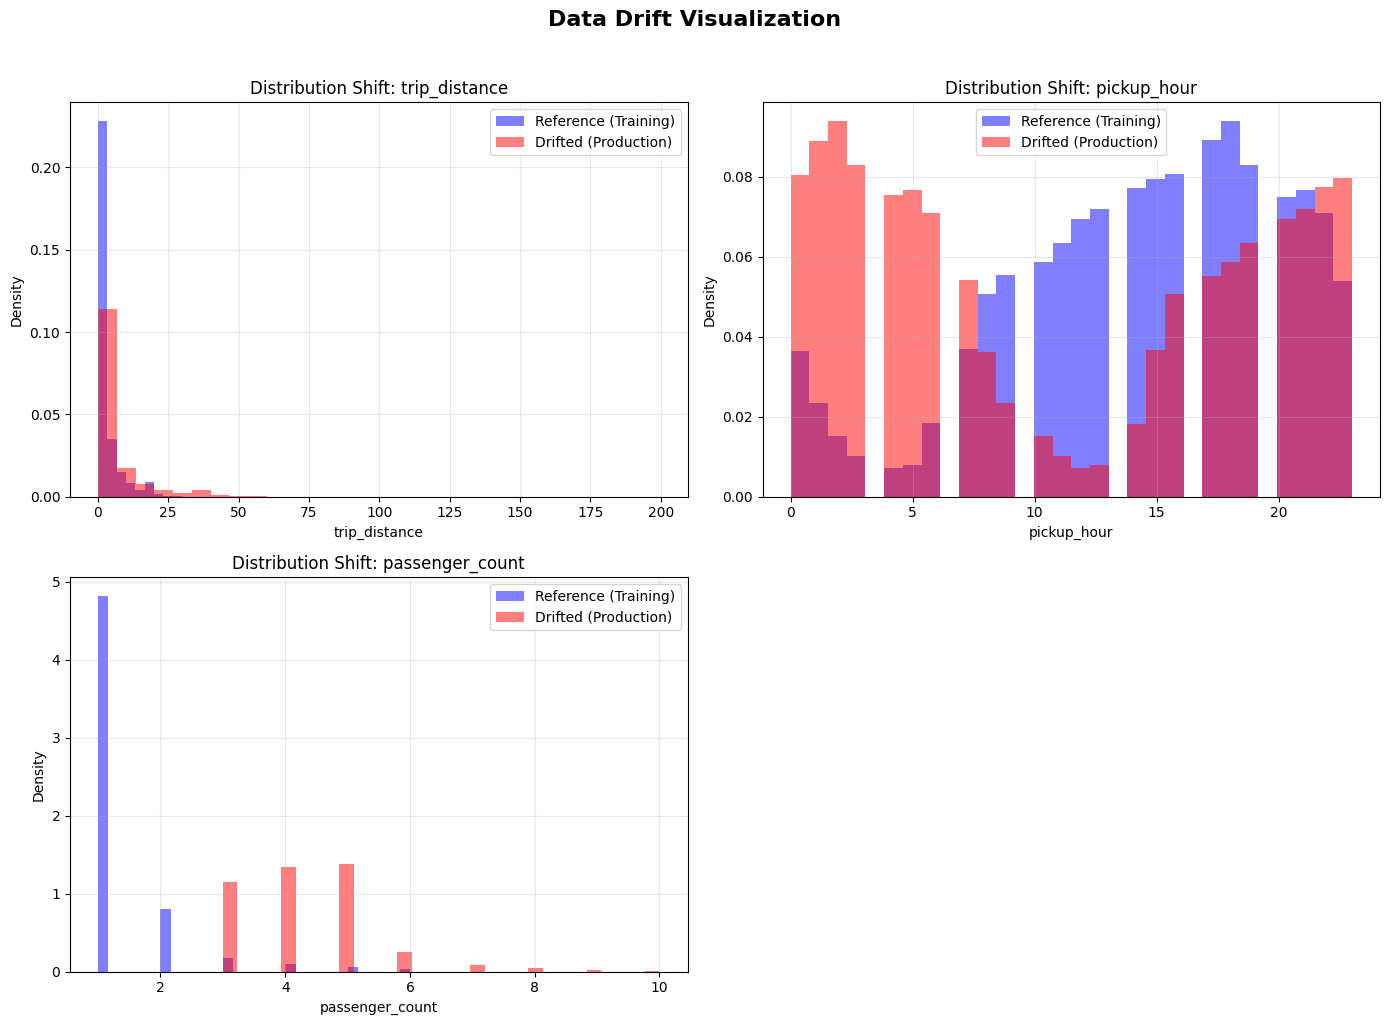

✅ Saved: ../monitoring/drift_visualization.png


In [22]:
# Visualize drifted features - using manual detection from previous cell
# Identify features with >10% change
drifted_features = []
key_features = ['trip_distance', 'pickup_hour', 'passenger_count'] if 'trip_distance' in ref_data.columns else numerical_features[:5]

for feature in key_features:
    if feature in ref_data.columns:
        ref_mean = ref_data[feature].mean()
        drift_mean = drift_data[feature].mean()
        change_pct = ((drift_mean - ref_mean) / ref_mean) * 100 if ref_mean != 0 else 0
        
        if abs(change_pct) > 10:  # Drift threshold: >10% change
            drifted_features.append(feature)

print(f"📊 Detected {len(drifted_features)} drifted features: {drifted_features}")

if drifted_features:
    n_features = min(4, len(drifted_features))
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(drifted_features[:4]):
        ax = axes[idx]
        
        # Plot distributions
        ax.hist(reference_data[feature], bins=30, alpha=0.5, label='Reference (Training)', color='blue', density=True)
        ax.hist(drifted_data[feature], bins=30, alpha=0.5, label='Drifted (Production)', color='red', density=True)
        
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.set_title(f'Distribution Shift: {feature}')
        ax.legend()
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_features, 4):
        axes[idx].set_visible(False)
    
    plt.suptitle('Data Drift Visualization', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(MONITORING_DIR / 'drift_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved: {MONITORING_DIR / 'drift_visualization.png'}")
else:
    print("✅ No significant drift detected in features")


## 7. Target Drift Detection

**Target Drift** terjadi ketika distribusi target variable berubah.

In [23]:
# Target Drift Report using ValueDrift
print("📊 Generating Target Drift Report...")

target_drift_report = Report(metrics=[
    ValueDrift(column='target'), 
    ValueDrift(column='prediction')
])

snapshot_target = target_drift_report.run(
    reference_data=ref_data,
    current_data=curr_data
)

# Save report
target_drift_path = MONITORING_DIR / 'target_drift_report.html'
snapshot_target.save_html(str(target_drift_path))
print(f"✅ Saved: {target_drift_path}")


📊 Generating Target Drift Report...
✅ Saved: ../monitoring/target_drift_report.html
✅ Saved: ../monitoring/target_drift_report.html


In [24]:
# Extract target drift results
target_drift_results = snapshot_target.dict()

print("📊 Target Drift Analysis:")
print(f"   Target (fare_amount): Check HTML report")
print(f"   Prediction: Check HTML report")
print(f"   Report saved to: {target_drift_path}")


📊 Target Drift Analysis:
   Target (fare_amount): Check HTML report
   Prediction: Check HTML report
   Report saved to: ../monitoring/target_drift_report.html


## 8. Model Performance Monitoring

In [26]:
# Regression Performance Report dengan Evidently 0.7.x
print("📊 Generating Model Performance Report using Evidently...")

# Import Dataset dan DataDefinition dari Evidently 0.7.x
from evidently.future.datasets import Dataset, DataDefinition, Regression
from evidently.metrics.regression import MAE, RMSE, R2Score

# Prepare data - rename columns to match Evidently expectations
ref_perf = reference_data[[TARGET, 'prediction']].copy().rename(columns={TARGET: 'target'})
curr_perf = current_data[[TARGET, 'prediction']].copy().rename(columns={TARGET: 'target'})

# Create DataDefinition with Regression task
regression_task = Regression(
    name='default',
    target='target',
    prediction='prediction'
)

data_def = DataDefinition(
    regression=[regression_task]
)

# Create Datasets using from_pandas
ref_dataset = Dataset.from_pandas(data=ref_perf.sample(n=min(SAMPLE_SIZE, len(ref_perf)), random_state=42), 
                                   data_definition=data_def)
curr_dataset = Dataset.from_pandas(data=curr_perf.sample(n=min(SAMPLE_SIZE, len(curr_perf)), random_state=42), 
                                    data_definition=data_def)

# Create report with Evidently regression metrics
regression_report = Report(metrics=[
    MAE(),
    RMSE(),
    R2Score()
])

# Run report with Dataset objects
snapshot_regression = regression_report.run(
    reference_data=ref_dataset,
    current_data=curr_dataset
)

# Save report
regression_report_path = MONITORING_DIR / 'regression_performance_report.html'
snapshot_regression.save_html(str(regression_report_path))
print(f"✅ Saved: {regression_report_path}")

# Display metrics summary
print("\n📈 Evidently Regression Metrics (from Report):")
print("   Report generated successfully - check HTML for details")


📊 Generating Model Performance Report using Evidently...
✅ Saved: ../monitoring/regression_performance_report.html

📈 Evidently Regression Metrics (from Report):
   Report generated successfully - check HTML for details
✅ Saved: ../monitoring/regression_performance_report.html

📈 Evidently Regression Metrics (from Report):
   Report generated successfully - check HTML for details


In [27]:
# Compare performance: Reference vs Current
def calculate_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

ref_metrics = calculate_metrics(reference_data[TARGET], reference_data['prediction'])
curr_metrics = calculate_metrics(current_data[TARGET], current_data['prediction'])
drift_metrics = calculate_metrics(drifted_data[TARGET], drifted_data['prediction'])

print("📊 Model Performance Comparison:")
print("="*70)
print(f"{'Metric':<10} {'Reference (Train)':>18} {'Current (Test)':>18} {'Drifted':>18}")
print("-"*70)

for metric in ['MAE', 'RMSE', 'R2']:
    ref_val = ref_metrics[metric]
    curr_val = curr_metrics[metric]
    drift_val = drift_metrics[metric]
    
    if metric == 'R2':
        print(f"{metric:<10} {ref_val:>18.4f} {curr_val:>18.4f} {drift_val:>18.4f}")
    else:
        print(f"{metric:<10} ${ref_val:>17.4f} ${curr_val:>17.4f} ${drift_val:>17.4f}")

print("="*70)


📊 Model Performance Comparison:
Metric      Reference (Train)     Current (Test)            Drifted
----------------------------------------------------------------------
MAE        $           0.9780 $           1.0026 $          10.0772
RMSE       $           3.0551 $           3.2155 $          15.0047
R2                     0.9676             0.9643             0.2237


In [29]:
# Performance degradation analysis
mae_degradation = ((curr_metrics['MAE'] - ref_metrics['MAE']) / ref_metrics['MAE']) * 100
mae_degradation_drift = ((drift_metrics['MAE'] - ref_metrics['MAE']) / ref_metrics['MAE']) * 100

print("📊 Performance Degradation Analysis:")
print(f"   Normal Case (Test vs Train):")
print(f"      MAE Change: {mae_degradation:+.2f}%")
print(f"      Status: {'⚠️ Degraded' if mae_degradation > 10 else '✅ Acceptable'}")

print(f"\n   Drifted Case (Drifted vs Train):")
print(f"      MAE Change: {mae_degradation_drift:+.2f}%")
print(f"      Status: {'⚠️ Degraded' if mae_degradation_drift > 10 else '✅ Acceptable'}")


📊 Performance Degradation Analysis:
   Normal Case (Test vs Train):
      MAE Change: +2.51%
      Status: ✅ Acceptable

   Drifted Case (Drifted vs Train):
      MAE Change: +930.37%
      Status: ⚠️ Degraded


## 9. Comprehensive Monitoring Report

In [30]:
# Generate comprehensive monitoring report
print("📊 Generating Comprehensive Monitoring Report...")

# Untuk Evidently 0.7.x, kita perlu membuat 2 report terpisah:
# 1. Data Drift Report (menggunakan DataFrame biasa)
# 2. Regression Metrics Report (menggunakan Dataset dengan DataDefinition)

# ===== Part 1: Data Drift Report =====
from evidently.future.datasets import Dataset, DataDefinition, Regression
from evidently.metrics.regression import MAE, RMSE, R2Score

# Sample data untuk mencegah kernel crash
ref_sample = ref_data.sample(n=min(SAMPLE_SIZE, len(ref_data)), random_state=42)
curr_sample = curr_data.sample(n=min(SAMPLE_SIZE, len(curr_data)), random_state=42)

drift_report = Report(metrics=[DataDriftPreset()])
snapshot_drift = drift_report.run(reference_data=ref_sample, current_data=curr_sample)

# ===== Part 2: Regression Metrics Report =====
# Prepare data with proper DataDefinition
ref_perf = ref_sample[['target', 'prediction']].copy()
curr_perf = curr_sample[['target', 'prediction']].copy()

regression_task = Regression(name='default', target='target', prediction='prediction')
data_def = DataDefinition(regression=[regression_task])

ref_dataset = Dataset.from_pandas(data=ref_perf, data_definition=data_def)
curr_dataset = Dataset.from_pandas(data=curr_perf, data_definition=data_def)

regression_report = Report(metrics=[MAE(), RMSE(), R2Score()])
snapshot_regression = regression_report.run(reference_data=ref_dataset, current_data=curr_dataset)

# Save both reports
drift_path = MONITORING_DIR / 'comprehensive_drift_report.html'
regression_path = MONITORING_DIR / 'comprehensive_regression_report.html'

snapshot_drift.save_html(str(drift_path))
snapshot_regression.save_html(str(regression_path))

print(f"✅ Saved: {drift_path}")
print(f"✅ Saved: {regression_path}")
print("\n📋 Note: Comprehensive report split into 2 files due to Evidently 0.7.x API requirements")


📊 Generating Comprehensive Monitoring Report...
✅ Saved: ../monitoring/comprehensive_drift_report.html
✅ Saved: ../monitoring/comprehensive_regression_report.html

📋 Note: Comprehensive report split into 2 files due to Evidently 0.7.x API requirements
✅ Saved: ../monitoring/comprehensive_drift_report.html
✅ Saved: ../monitoring/comprehensive_regression_report.html

📋 Note: Comprehensive report split into 2 files due to Evidently 0.7.x API requirements


## 10. Alerting Thresholds & Recommendations

In [31]:
# Define alerting thresholds
ALERT_THRESHOLDS = {
    'drift_share': 0.3,           # Alert if >30% features drifted
    'mae_increase_pct': 15,       # Alert if MAE increases >15%
    'r2_decrease': 0.05,          # Alert if R² decreases >0.05
    'max_mae': 3.5                # Alert if MAE > $3.50
}

print("📊 Alerting Thresholds:")
for key, value in ALERT_THRESHOLDS.items():
    print(f"   {key}: {value}")


📊 Alerting Thresholds:
   drift_share: 0.3
   mae_increase_pct: 15
   r2_decrease: 0.05
   max_mae: 3.5


In [32]:
# Check alerts - Manual implementation
def check_alerts(ref_metrics, curr_metrics, thresholds):
    alerts = []
    
    # Check MAE increase
    mae_increase = ((curr_metrics['MAE'] - ref_metrics['MAE']) / ref_metrics['MAE']) * 100
    if mae_increase > thresholds['mae_increase_pct']:
        alerts.append(f"🚨 MAE INCREASED: {mae_increase:.1f}% (threshold: {thresholds['mae_increase_pct']}%)")
    
    # Check absolute MAE
    if curr_metrics['MAE'] > thresholds['max_mae']:
        alerts.append(f"🚨 HIGH MAE: ${curr_metrics['MAE']:.2f} (threshold: ${thresholds['max_mae']:.2f})")
    
    # Check R² decrease
    r2_decrease = ref_metrics['R2'] - curr_metrics['R2']
    if r2_decrease > thresholds['r2_decrease']:
        alerts.append(f"🚨 R² DECREASED: -{r2_decrease:.4f} (threshold: {thresholds['r2_decrease']})")
    
    return alerts

# Check normal case
print("\n📊 Alert Check (Normal Case - Test vs Train):")
print("-"*50)
alerts_normal = check_alerts(ref_metrics, curr_metrics, ALERT_THRESHOLDS)

if alerts_normal:
    for alert in alerts_normal:
        print(f"   {alert}")
else:
    print("   ✅ All metrics within acceptable thresholds")

# Check drifted case
print("\n📊 Alert Check (Drifted Case - Simulated Drift):")
print("-"*50)
alerts_drifted = check_alerts(ref_metrics, drift_metrics, ALERT_THRESHOLDS)

if alerts_drifted:
    for alert in alerts_drifted:
        print(f"   {alert}")
else:
    print("   ✅ All metrics within acceptable thresholds")



📊 Alert Check (Normal Case - Test vs Train):
--------------------------------------------------
   ✅ All metrics within acceptable thresholds

📊 Alert Check (Drifted Case - Simulated Drift):
--------------------------------------------------
   🚨 MAE INCREASED: 930.4% (threshold: 15%)
   🚨 HIGH MAE: $10.08 (threshold: $3.50)
   🚨 R² DECREASED: -0.7439 (threshold: 0.05)


## 11. Save Monitoring Results

In [33]:
# Save monitoring results
monitoring_results = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_name': MODEL_NAME,
    'reference_size': len(reference_data),
    'current_size': len(current_data),
    'performance': {
        'reference': ref_metrics,
        'current': curr_metrics,
        'drifted': drift_metrics
    },
    'alert_thresholds': ALERT_THRESHOLDS,
    'alerts': {
        'normal_case': alerts_normal,
        'drifted_case': alerts_drifted
    }
}

# Save results
results_path = MONITORING_DIR / 'monitoring_results.joblib'
joblib.dump(monitoring_results, results_path)
print(f"✅ Saved monitoring results: {results_path}")


✅ Saved monitoring results: ../monitoring/monitoring_results.joblib


## 12. Summary

In [ ]:
print("="*70)
print("              📋 MONITORING & DRIFT DETECTION SUMMARY")
print("="*70)

mae_degradation = ((curr_metrics['MAE'] - ref_metrics['MAE']) / ref_metrics['MAE']) * 100
mae_degradation_drift = ((drift_metrics['MAE'] - ref_metrics['MAE']) / ref_metrics['MAE']) * 100

print(f"""
MODEL INFORMATION:
   Model: {MODEL_NAME}
   Reference Data: {len(reference_data):,} rows (Training)
   Current Data: {len(current_data):,} rows (Test/Production)

PERFORMANCE MONITORING:
   Reference MAE: ${ref_metrics['MAE']:.4f}
   Current MAE:   ${curr_metrics['MAE']:.4f} ({mae_degradation:+.1f}%)
   Drifted MAE:   ${drift_metrics['MAE']:.4f} ({mae_degradation_drift:+.1f}%)

ALERTING STATUS:
   Normal Case: {'✅ OK' if not alerts_normal else '⚠️ ALERTS TRIGGERED'}
   Drifted Case: {'✅ OK' if not alerts_drifted else '⚠️ ALERTS TRIGGERED'}

GENERATED REPORTS:
   📁 {MONITORING_DIR}/
      - data_drift_report_normal.html
      - data_drift_report_drifted.html
      - target_drift_report.html
      - regression_performance_report.html
      - comprehensive_monitoring_report.html
      - drift_visualization.png
      - monitoring_results.joblib
""")

print("RECOMMENDATIONS:")
print("   1. Set up automated monitoring script (src/monitoring/monitor.py)")
print("   2. Schedule periodic drift checks (daily/weekly)")
print("   3. Configure email/slack alerts for drift detection")
print("   4. Retrain model when performance degrades >15%")
print("   5. Investigate root cause of drifted features")

print("\n" + "="*70)
print("✅ Monitoring Setup Complete!")
print("   Next: Create production scripts & deployment")
print("="*70)


              📋 MONITORING & DRIFT DETECTION SUMMARY

MODEL INFORMATION:
   Model: random_forest
   Reference Data: 11,168,247 rows (Training)
   Current Data: 2,393,196 rows (Test/Production)

PERFORMANCE MONITORING:
   Reference MAE: $0.9780
   Current MAE:   $1.0026 (+2.5%)
   Drifted MAE:   $10.0772 (+930.4%)

ALERTING STATUS:
   Normal Case: ✅ OK
   Drifted Case: ⚠️ ALERTS TRIGGERED

GENERATED REPORTS:
   📁 ../monitoring/
      - data_drift_report_normal.html
      - data_drift_report_drifted.html
      - target_drift_report.html
      - regression_performance_report.html
      - comprehensive_monitoring_report.html
      - drift_visualization.png
      - monitoring_results.joblib

RECOMMENDATIONS:
   1. Set up automated monitoring script (src/monitoring/monitor.py)
   2. Schedule periodic drift checks (daily/weekly)
   3. Configure email/slack alerts for drift detection
   4. Retrain model when performance degrades >15%
   5. Investigate root cause of drifted features

✅ Monitori

: 

---

## 🔗 Untuk Dosen: Cara Kerja Monitoring

### Apa yang terjadi jika ada Data Drift?

1. **Detection**: Evidently membandingkan distribusi data production dengan training data
2. **Alert**: Jika drift share > 30%, sistem mengirim alert
3. **Investigation**: Tim ML melihat fitur mana yang drift
4. **Action**: 
   - Minor drift: Monitor saja
   - Major drift: Retrain model dengan data baru

### Workflow Production:
```
[New Data] → [Drift Check] → [Alert?] → [Retrain if needed]
     ↓              ↓             ↓
 Prediction   Generate Report   Email/Slack
```

### Next Steps
1. **run_pipeline.py** - One-click automation
2. **monitor.py** - Automated drift detection script
3. **app.py (Streamlit)** - Demo UI
4. **CI/CD** - GitHub Actions workflow

In [ ]:

# Load test data
test_df = pd.read_parquet('data/processed/test.parquet')
train_df = pd.read_parquet('data/processed/train.parquet')

print('📊 TRAIN DATA HEAD:')
print('='*80)
print(train_df.head().to_string())
print(f'\nShape: {train_df.shape}')
print(f'Columns: {list(train_df.columns)}')

print('\n\n📊 TEST DATA HEAD:')
print('='*80)
print(test_df.head().to_string())
print(f'\nShape: {test_df.shape}')
"
